# Exploration of new energy-dependent USU functionality

In this notebook, we study the impact of the inclusion of energy-dependent USU uncertainties **for U5(n,f) and PU9(n,f)** on the evaluation **using the full GMA database**. The Bayesian update formula is the starting point,
$$ \rho(\vec{\sigma} \,|\, \vec{m}, \Sigma) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma) \times \rho(\vec{\sigma})$$
with $\vec{\sigma}$ the true cross sections that shall be determined, $\vec{m}$ the measured values and $\Sigma$ the experimental covariance matrix. The model $\mathcal{M}$ is responsible for mapping the cross sections given on the energy grid of $\vec{\sigma}$ to the energies of the measured values given in $\vec{m}$. If $\mathcal{M}$ is linear and the distributions on the right-hand side multivariate normal, also the posterior distribution (left-hand side) is multivariate normal whose center vector and covariance matrix can be obtained by the GLS equations.

For the consideration of energy-dependent USU, we introduce the following additional assumptions: Each dataset is associated with USU **errors** at a pre-defined energy mesh (e.g. 1, 2, 3, 4 MeV). These USU errors can not be measured and are unknown, therefore they are associated with an USU **uncertainty**. So for each energy $E_i$, each dataset $j$ has an USU **error** $\varepsilon_{ij}$. All USU errors at the same incident energy are associated with the same USU uncertainty $u_i$. We assume that the USU error at intermediate energies is given by linear interpolation of the USU errors at the enclosing energy points. Performing marginalization (integrating over the USU errors), yields a model where only the USU uncertainties remain, which are effectively parameters in the covariance matrix. The above statistical model therefore is modified in the following way:
$$ \rho(\vec{\sigma}, \Sigma(\vec{u}) \,|\, \vec{m}) \propto \rho(\vec{m} \,|\, \mathcal{M}, \vec{\sigma}, \Sigma(\vec{u})) \times \rho(\vec{\sigma}) \times \rho(\vec{u})$$
As can be seen, an additional prior distribution $\rho(\vec{u})$ is imposed on the USU uncertainties. We assume a uniform distribution from 0 to $+\infty$ for each element $u_i$ of the vector $\vec{u}$. The experimental covariance matrix is given by the covariance matrix from the GMA database file augmented with contributions from the energy-dependent USU uncertainties. With this augmented specification, there is no longer an analytic formula to calculate moments of the posterior distribution and we need to resort to Monte Carlo sampling. The Hamilton Monte Carlo algorithm can efficiently generate samples from the posterior distribution.

In the following, the results are presented for the simple toy scenario. The code to produce plots and results can be ignored. Text is provided in-between plots to explain the meaning of plots and results.

## Loading required packages and result files

Essential Python packages for visualiztion are loaded. In addition we prepare some quantities here, such as covariance matrices. The presentation of results start in the next section.

In [1]:
import sys
sys.path.append('../..')
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gmapy.data_management.object_utils import (
    load_objects, save_objects
)
import seaborn as sns
import tensorflow as tf
from gmapy.mappings.tf.compound_map_tf import CompoundMap
from gmapy.mappings.tf.restricted_map import RestrictedMap
from gmapy.mcmc_inference import compute_effective_sample_size, compute_acceptance_rate

2023-11-17 16:58:08.588337: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-17 16:58:08.589736: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:58:08.617743: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 16:58:08.618232: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-17 16:58:09.111747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
thisdir = 'example-008/output/'
otherdir = 'example-005/output_backup/'
chain_relcov_usu, = load_objects(thisdir + '03_mcmc_sampling_output.pkl', 'chain')
priortable, exptable, expcov, compmap, num_covpars, is_adj = load_objects(thisdir + '01_model_preparation_output.pkl',
    'priortable', 'exptable', 'expcov', 'compmap', 'num_covpars', 'is_adj')
# load the experimental covariance matrices
like_cov_fun_rel_usu, usu_df, red_usu_df = load_objects(thisdir + '01_model_preparation_output.pkl', 'like_cov_fun', 'usu_df', 'red_usu_df')
expcov_rel_nousu, = load_objects(otherdir + '01_model_preparation_output.pkl', 'expcov_linop')
# for comparison, without usu and relative
chain_relcov_nousu, = load_objects(otherdir + '03_mcmc_sampling_output.pkl', 'chain')
#chain_abscov_nousu, = load_objectsididcs = priortable.index[(priortable.REAC == cur_reac) & (priortable.ENERGY >= 1) & (priortable.ENERGY <= 8)]cs = priortable.index[(priortable.REAC == cur_reac) & (priortable.ENERGY >= 1) & (priortable.ENERGY <= 8)]('../example-003/output/03_mcmc_sampling_output.pkl', 'chain')
red_priortable = priortable[is_adj].reset_index(drop=True)  # remove the constant fission spectrum

In [3]:
priorvals = priortable.PRIOR.to_numpy(copy=True)
adj_idcs = np.where(is_adj)[0]
fixed_idcs = np.where(~is_adj)[0]
restrimap = RestrictedMap(
    len(priorvals), compmap.propagate, compmap.jacobian,
    fixed_params=priorvals[fixed_idcs], fixed_params_idcs=fixed_idcs
)

In [4]:
# prepare absolute covmat
expvals = exptable.DATA.to_numpy()
#absexpcov = expcov.toarray() # * expvals.reshape((-1, 1)) * expvals.reshape((1, -1))
#absexpuncs = np.sqrt(absexpcov.diagonal())
#exptable['UNC'] = absexpuncs

## Laplace approximation

In [5]:
optres, = load_objects(otherdir + '02_parameter_optimization_output.pkl', 'optres')
post, = load_objects(otherdir + '01_model_preparation_output.pkl', 'post')
neg_hess = post.neg_log_prob_hessian(optres.position)

In [6]:
postcov = np.linalg.inv(neg_hess)
postuncs_laplace = np.sqrt(postcov.diagonal())
postvals_laplace = optres.position
post_usu_uncs_laplace = np.abs(postvals_laplace.numpy()[-num_covpars:])
priortable.loc[is_adj, 'POST_LAPLACE'] = postvals_laplace.numpy()[:len(priortable.loc[is_adj])]
priortable.loc[is_adj, 'POSTUNC_LAPLACE'] = postuncs_laplace[:len(priortable.loc[is_adj])] / postvals_laplace.numpy()[:len(priortable.loc[is_adj])]
priortable

,NODE,REAC,ENERGY,PRIOR,UNC,DESCR,POST_LAPLACE,POSTUNC_LAPLACE
0,xsid_1,MT:1-R1:1,2.530000e-08,938.100000,inf,"6Li(n,a)",938.145936,0.000580
1,xsid_1,MT:1-R1:1,9.400000e-06,48.640000,inf,"6Li(n,a)",48.640556,0.000580
2,xsid_1,MT:1-R1:1,1.500000e-04,12.160000,inf,"6Li(n,a)",12.160897,0.000332
3,xsid_1,MT:1-R1:1,2.500000e-04,9.413000,inf,"6Li(n,a)",9.413174,0.000391
4,xsid_1,MT:1-R1:1,3.500000e-04,7.954000,inf,"6Li(n,a)",7.952050,0.000381
...,...,...,...,...,...,...,...,...
1225,norm_589,MT:2-R1:9,0.000000e+00,0.985653,inf,NaN,0.968143,0.021705
1226,norm_635,MT:4-R1:9-R2:8,0.000000e+00,0.987291,inf,NaN,0.986117,0.024753
1227,norm_1028,MT:2-R1:8,0.000000e+00,0.987727,inf,NaN,0.990886,0.007845
1228,norm_1033,MT:2-R1:4,0.000000e+00,0.983214,inf,NaN,0.996765,0.010368


## Original experimental data

First we plot the experimental data along with their uncertainties to obtain a visual impression of the degree of inconsistency. All points lie on the same discrete energy grid so we apply a bit of jitter on the energies to make the points and errorbars visually distinguishable. 

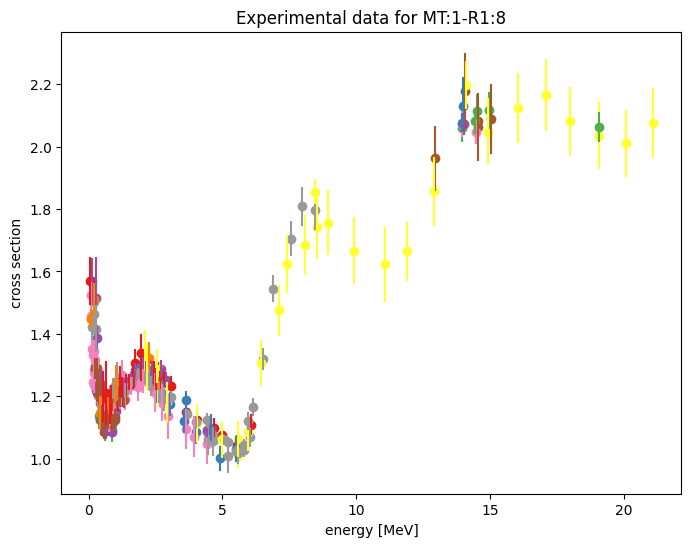

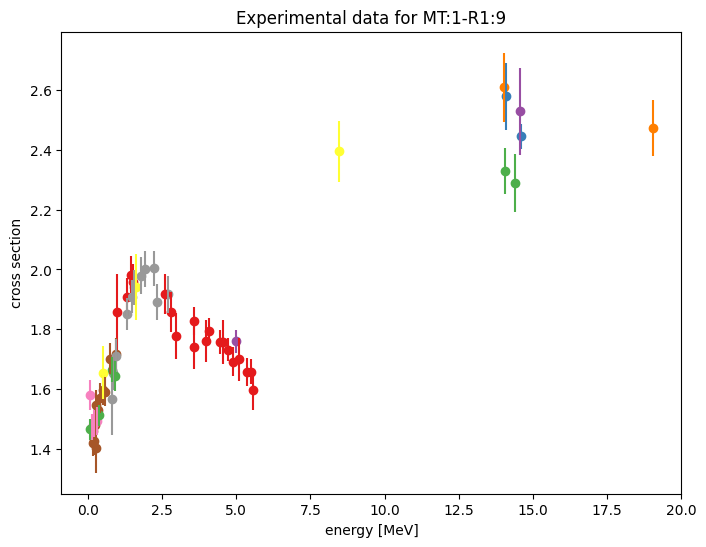

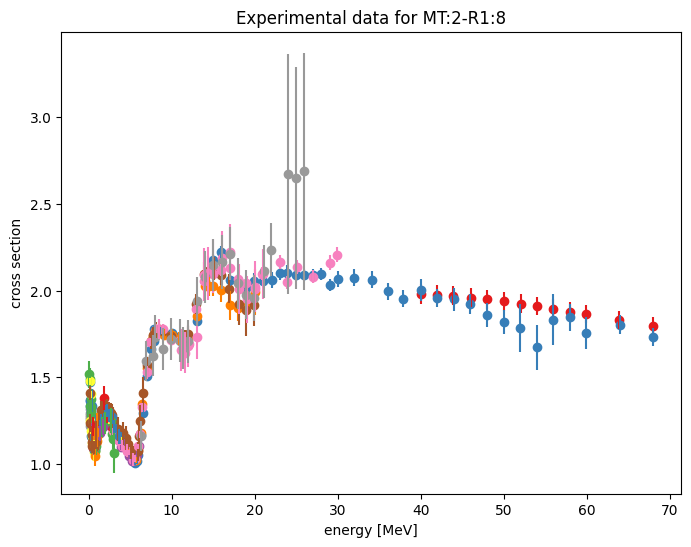

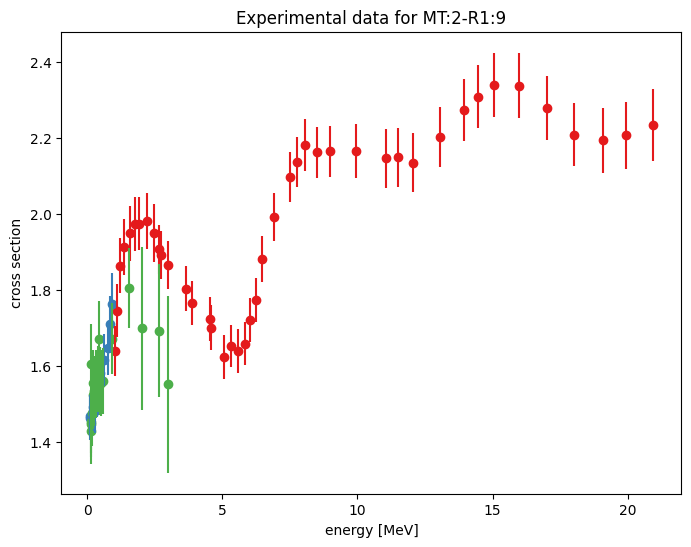

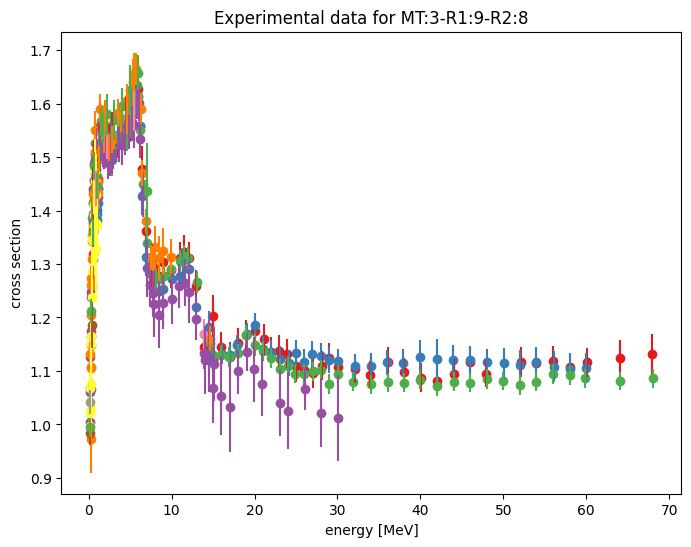

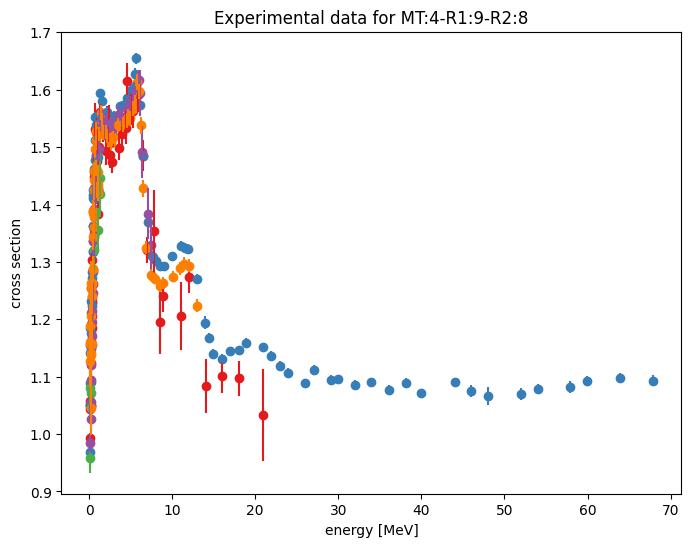

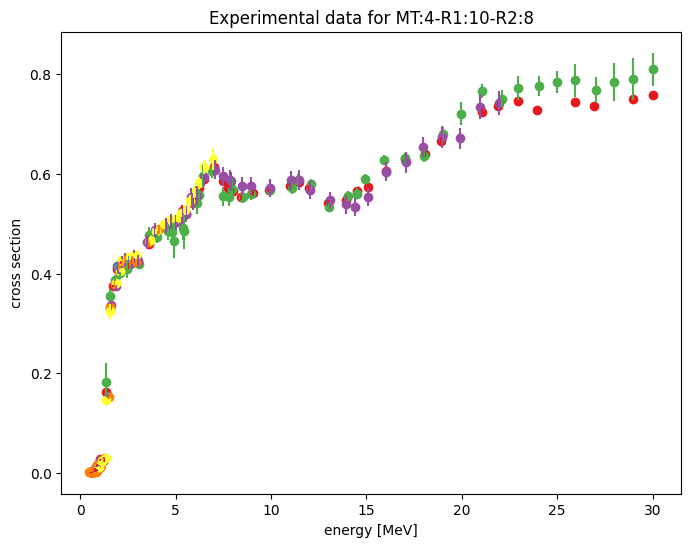

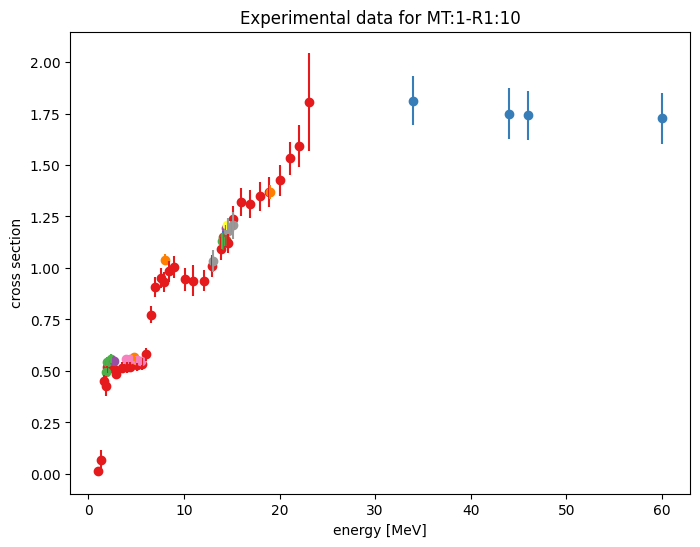

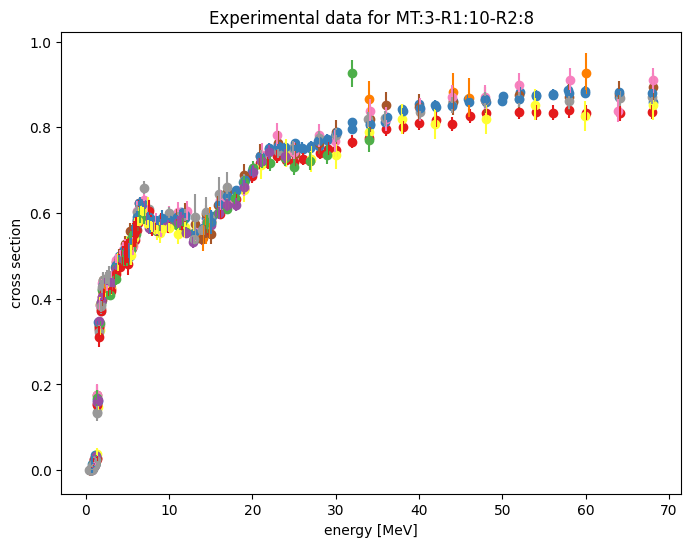

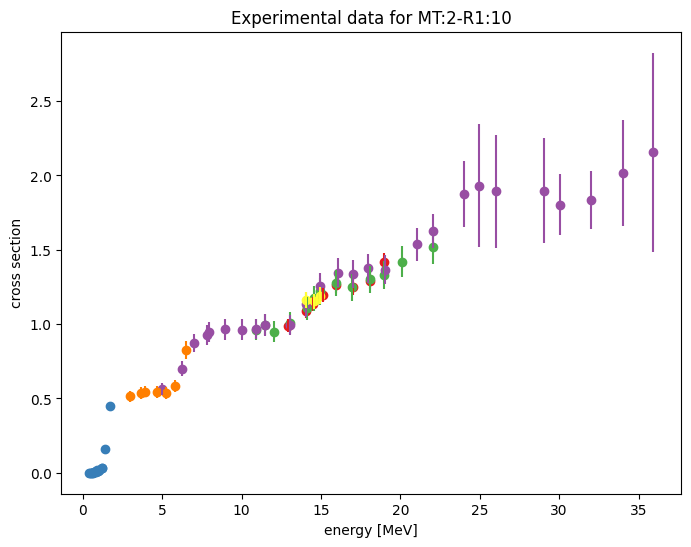

In [7]:
def plot_expdata(reacs, energy_limits, jitter=0.03, ylims=None, plotly=False):
    if isinstance(jitter, float):
        jitter_list = [jitter] * len(reacs)
    else:
        jitter_list = jitter
    if ylims is None:
        ylims = [[None, None]] * len(reacs)
    for cur_reac, en_limit, cur_ylim, cur_jitter in zip(reacs, energy_limits, ylims, jitter_list):
        red_exptable = exptable[
            exptable.REAC.str.match(cur_reac) & (exptable.ENERGY > en_limit[0]) &
            (exptable.ENERGY < en_limit[1])
        ].copy()
        red_exptable['DESCR'] = (red_exptable['NODE'].str.strip() + ' / ' + 
                                 red_exptable['AUTHOR'].str.strip() + ' / ' + red_exptable['PUBREF'].str.strip())
        num_groups = len(red_exptable['NODE'].unique())
        color_palette = sns.color_palette("Set1", n_colors=num_groups)
        ens = red_exptable['ENERGY']
        jittered_x = red_exptable['ENERGY'] + np.random.uniform(-cur_jitter, cur_jitter, len(red_exptable))
        red_exptable['jitx'] = jittered_x
        if not plotly:
            plt.figure(figsize=(8,6))
            for i, (group, group_data) in enumerate(red_exptable.groupby('NODE')):
                color = color_palette[i]
                plt.scatter(group_data['jitx'], group_data['DATA'], color=color)
                plt.errorbar(group_data['jitx'], group_data['DATA'], yerr=group_data['UNC'], color=color, linestyle='')
            plt.title(f'Experimental data for {cur_reac}')
            plt.xlabel('energy [MeV]')
            plt.ylim(cur_ylim[0], cur_ylim[1])
            plt.ylabel('cross section')
        else:
            fig = px.scatter(red_exptable, x='jitx', y='DATA', error_y='UNC', color='DESCR', title=f'Experimental data for {cur_reac}')
            fig.show()

plot_reacs = ('MT:1-R1:8', 'MT:1-R1:9', 'MT:2-R1:8', 'MT:2-R1:9', 'MT:3-R1:9-R2:8', 'MT:4-R1:9-R2:8')
plot_reacs = plot_reacs + tuple(['MT:4-R1:10-R2:8', 'MT:1-R1:10', 'MT:3-R1:10-R2:8', 'MT:2-R1:10'])
plot_expdata(plot_reacs, [[0.1, 70]]*len(plot_reacs), jitter=0.1, plotly=False)

## Determination of USU uncertainties

As mentioned above, USU uncertainties are given on a pre-defined energy mesh (e.g., 1, 2, 3, 4 MeV). They characterize how much the USU errors are expected to scatter. The following plots show the posterior distribution of the USU uncertainty at the respective energy points. As all the experimental data are between 1 and 2 MeV, the posterior of the USU uncertainty at 1 and 2 MeV are peaked with the maximum of the distribution being at about 2\%. In contrast, no experimental data points are above 2 MeV, so there is no experimental information there to inform USU uncertainties. Therefore, the distributions for those cases are very uninformative, hence samples of the USU uncertainty span many orders of magnitude. Normally, it is a waste of computational power to include variables where we know that they are not informed by the likelihood. It is done here merely to demonstrate that the procedure yields the expected result. Please also note that the shape of histograms above 2 MeV should be ignored as it is impossible to converge an improper flat prior distribution from 0 to $+\infty$ without feedback from experimental data.

In [8]:
red_usu_df['POST_MEAN'] = np.mean(np.abs(chain_relcov_usu[:, -num_covpars:]), axis=0)
red_usu_df['POST_STD'] = np.std(np.abs(chain_relcov_usu[:, -num_covpars:]), axis=0)
red_usu_df

,REAC,ENERGY,POST_MEAN,POST_STD
0,MT:1-R1:8,0.0,0.007944,0.005423
1,MT:1-R1:8,1.0,0.008237,0.005873
2,MT:1-R1:8,2.0,0.014860,0.006745
3,MT:1-R1:8,6.0,0.012770,0.010275
4,MT:1-R1:8,12.0,0.047839,0.030221
5,MT:1-R1:8,14.5,0.009538,0.008299
6,MT:1-R1:8,20.0,0.040308,0.057454
7,MT:1-R1:9,0.0,0.023639,0.014975
8,MT:1-R1:9,1.0,0.027908,0.029534
9,MT:1-R1:9,2.0,0.018879,0.021312


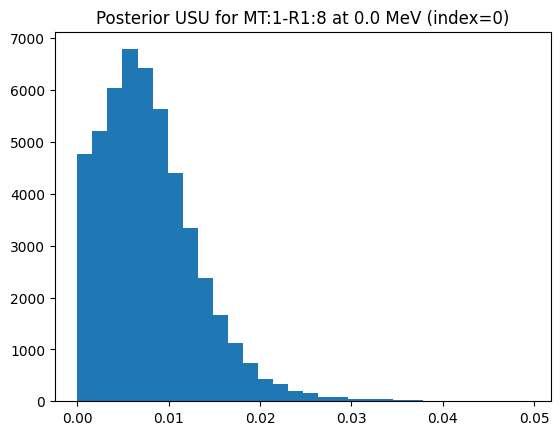

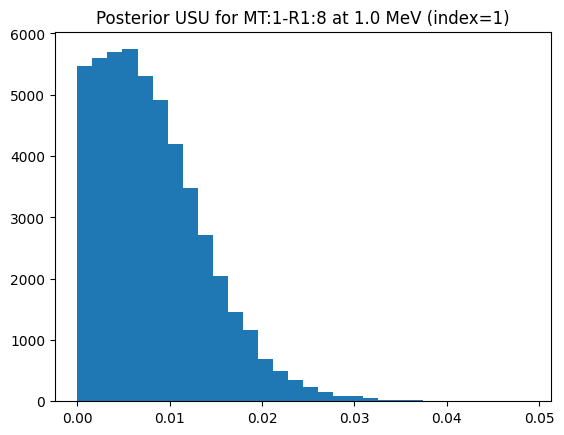

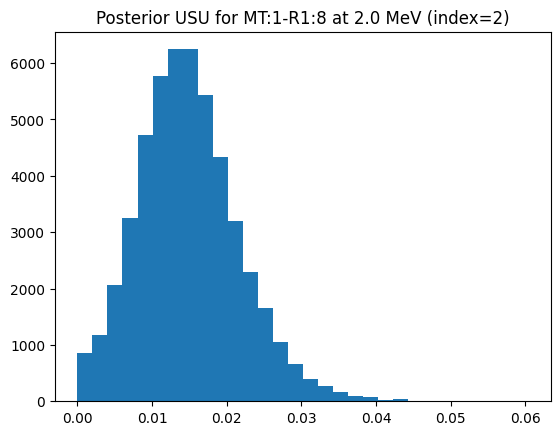

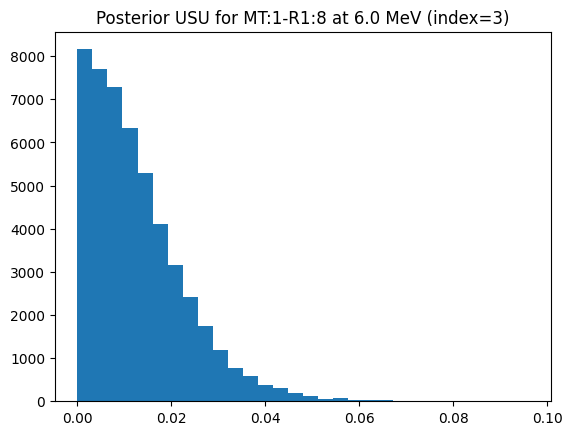

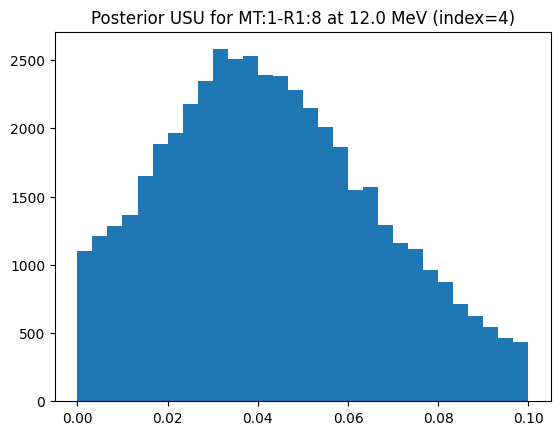

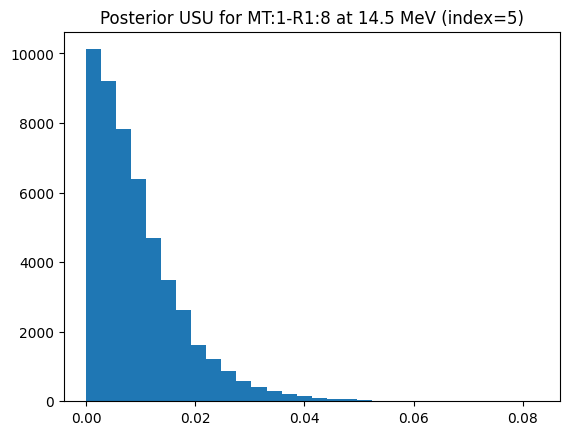

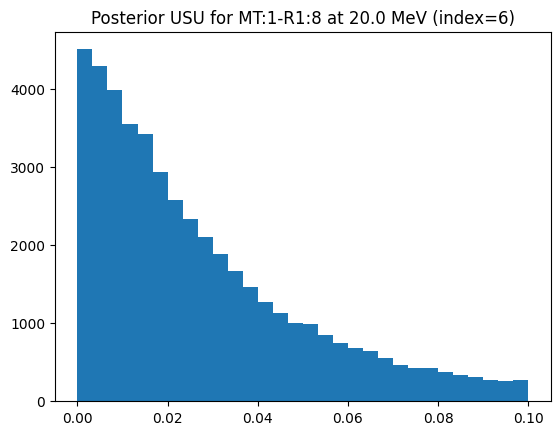

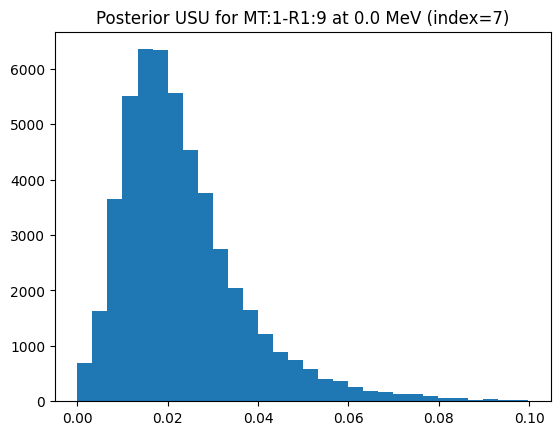

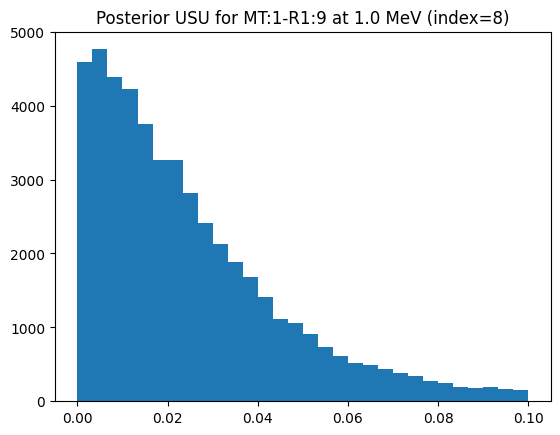

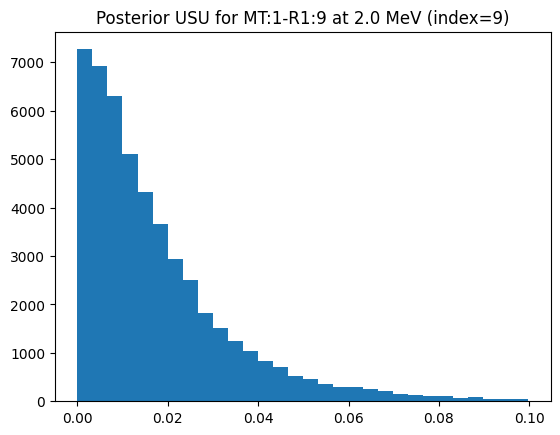

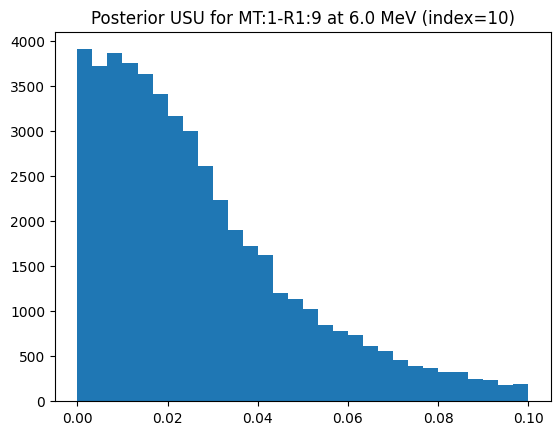

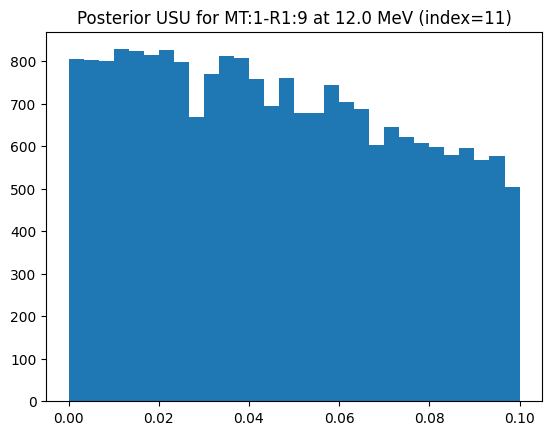

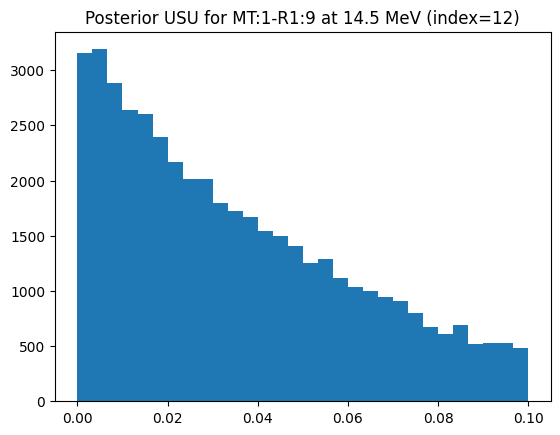

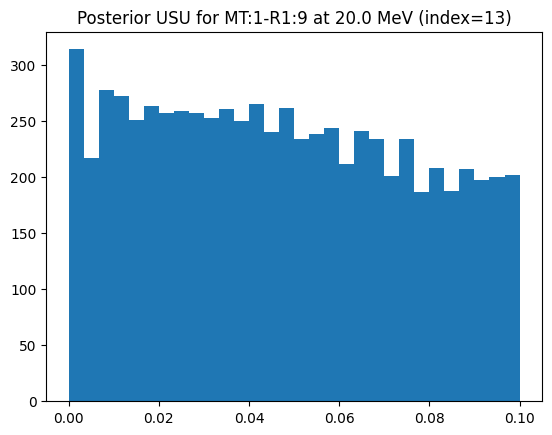

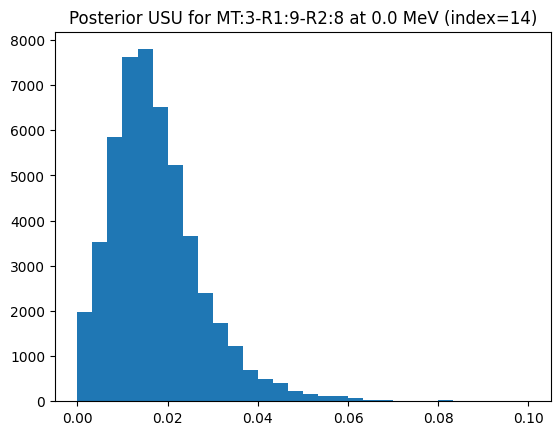

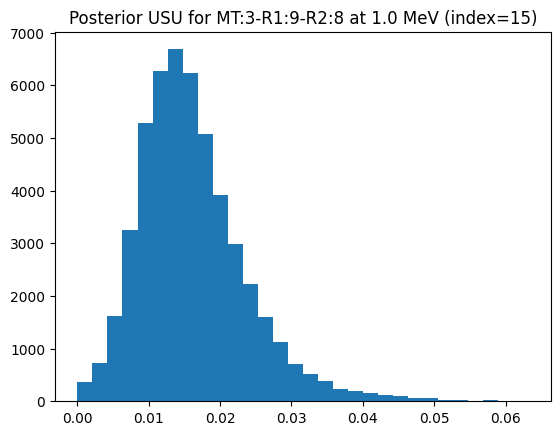

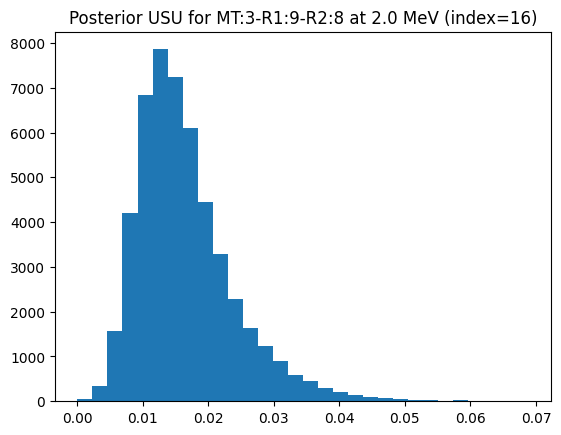

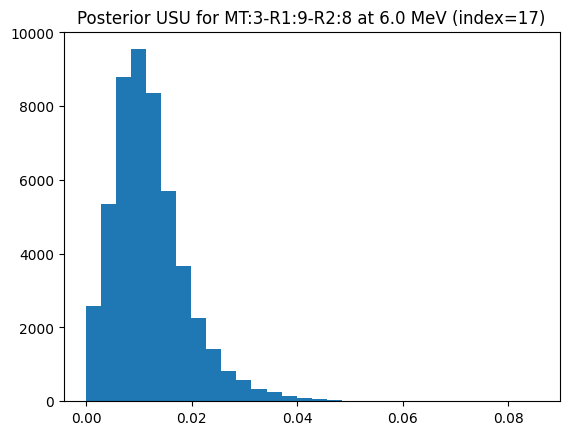

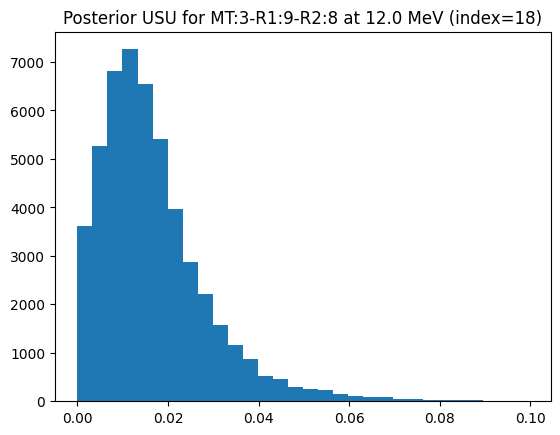

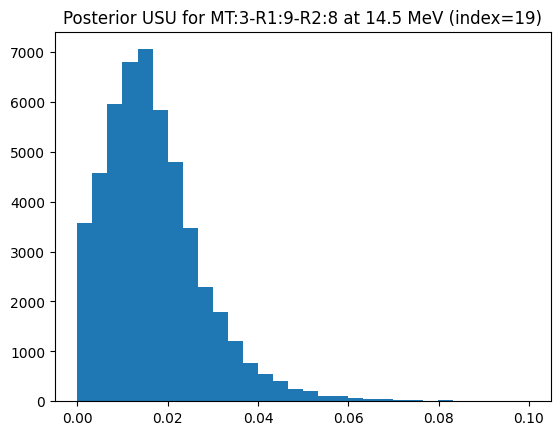

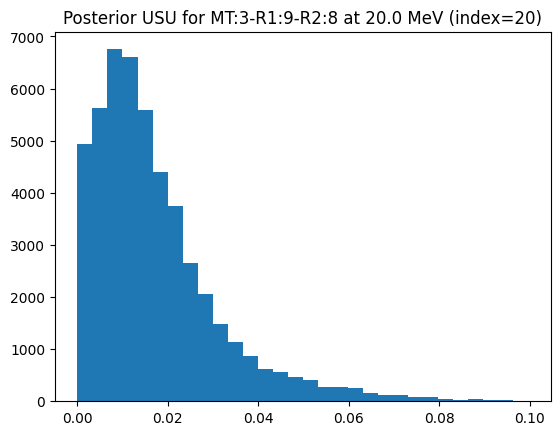

In [9]:
# plt.figure(figsize=(8, 6))
plot_num = 0
for index, row in red_usu_df.iterrows():
    tmp = np.abs(chain_relcov_usu[:,-num_covpars+index])
    tmp = tmp[tmp < 0.1]
    plt.hist(tmp, bins=30)
    plt.title(f'Posterior USU for {row["REAC"]} at {row["ENERGY"]} MeV (index={index})')
    plt.show()

## Closer investigation of regions with significant non-zero USU

This plots are left here to demonstrate the capability of producing such plots. Depending on the case study, reactions and energies need to be adjusted.

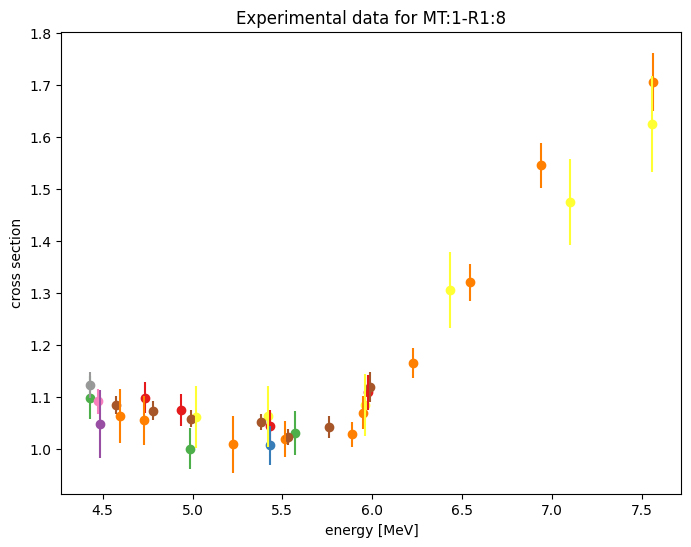

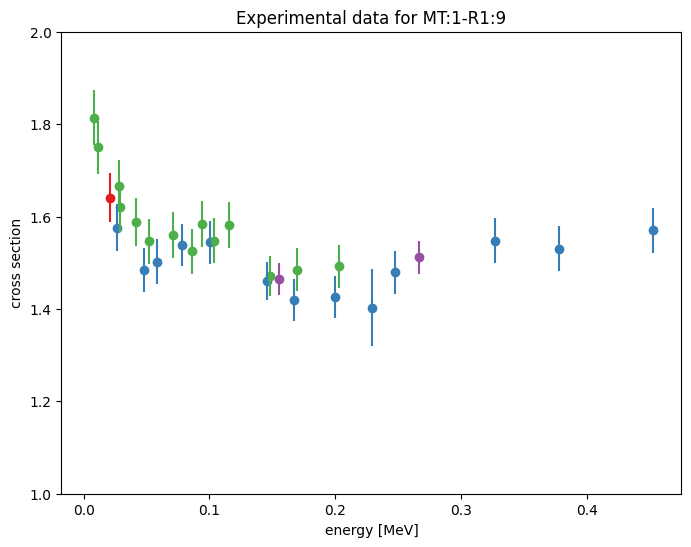

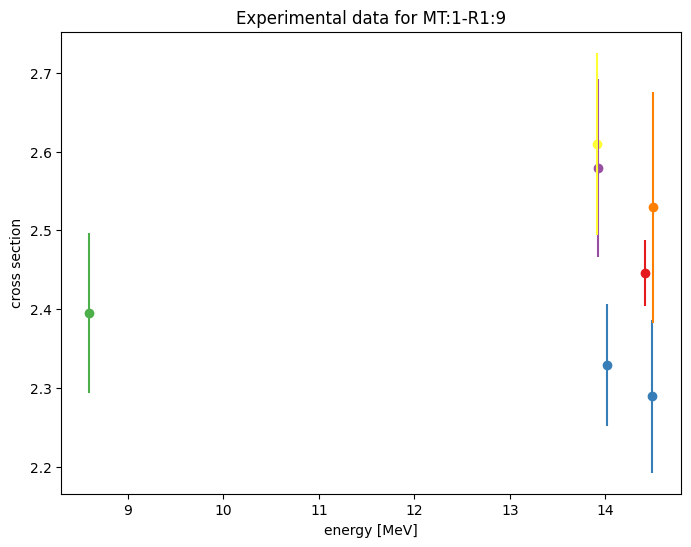

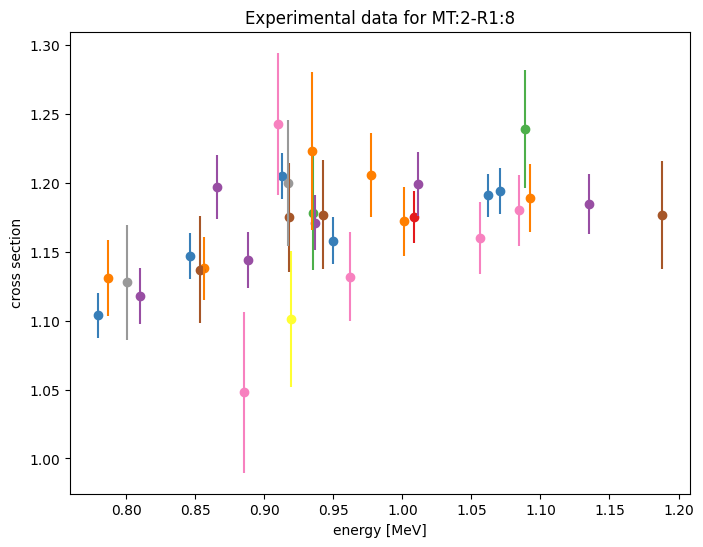

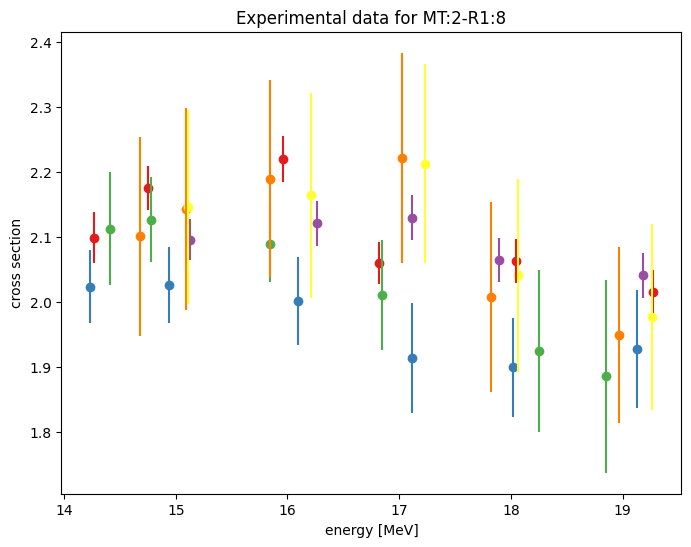

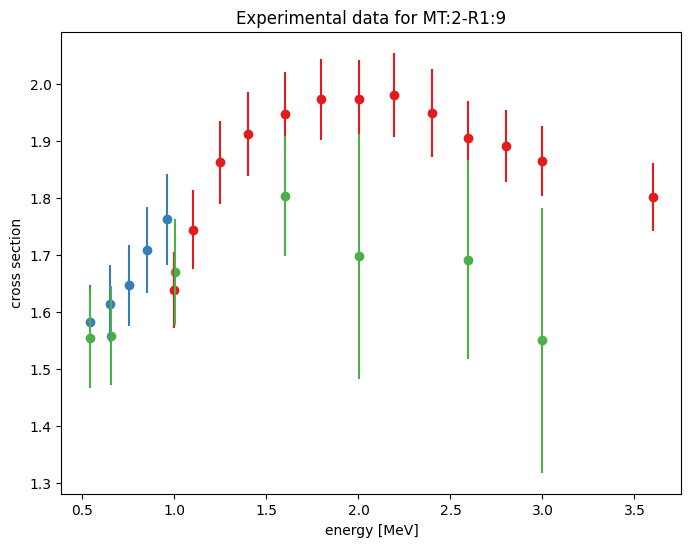

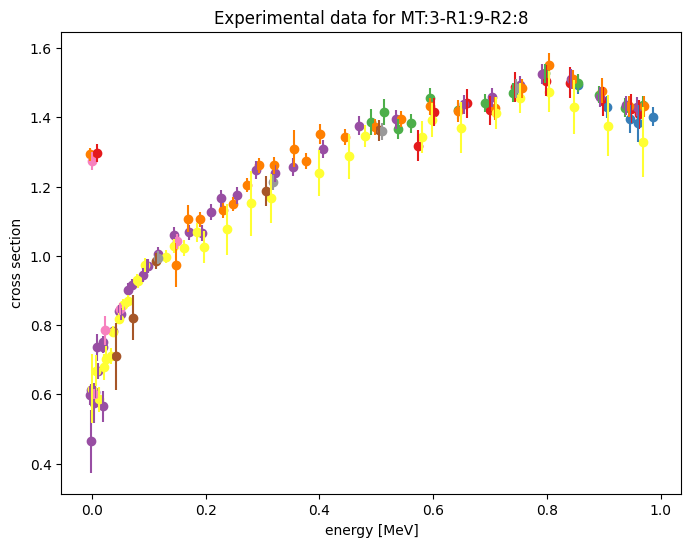

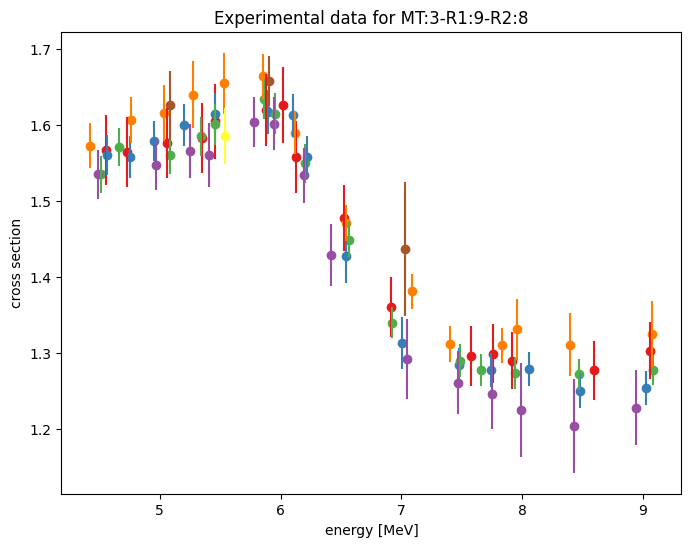

In [10]:
plot_expdata(reacs=('MT:1-R1:8', 'MT:1-R1:9', 'MT:1-R1:9', 'MT:2-R1:8', 'MT:2-R1:8', 'MT:2-R1:9',
                    'MT:3-R1:9-R2:8', 'MT:3-R1:9-R2:8'),
             energy_limits=[[4., 8.], [0.0, 0.5], [6., 17.], [0.8, 1.2], [14., 20.], [0.5, 4.],
                            [0, 1], [4, 10]],
             ylims=[[None, None], [1, 2], [None, None], [None, None], [None, None], [None, None],
                    [None, None], [None, None]],
             jitter=[0.1, 0.005, 0.1, 0.1, 0.3, 0.005,
                     0.01, 0.1])

## Impact of USU uncertainties on the evaluation mean values

USU uncertainties are inferred at the same time as the true cross sections. In the following we compare how an evaluation with the consideration of USU uncertainties is different from one without. We have studied three cases:

- **blue**: we use a relative experimental covariance matirx (~PPP correction) and take into account USU
- **green**: we use a relative experimental covariance matrix (~PPP correction) without USU
- **red**: we use an absolute experimental covariance matrix without USU

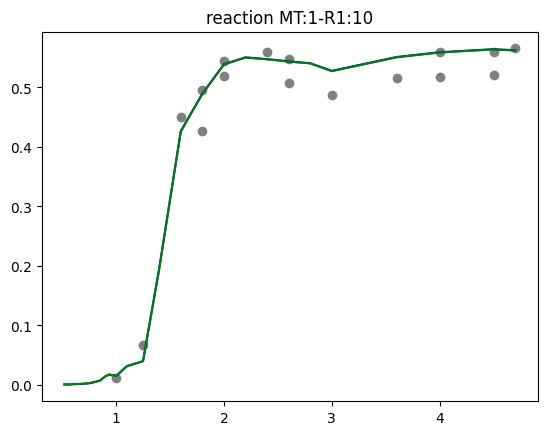

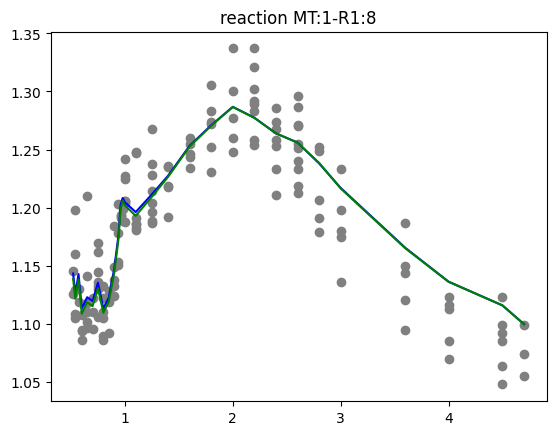

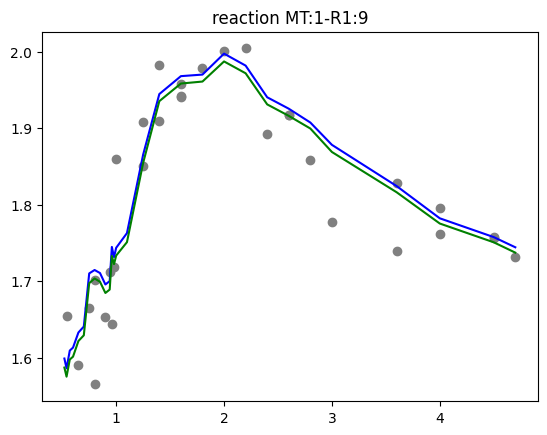

In [11]:
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:-num_covpars], axis=0)
postuncs_relcov_usu = np.std(chain_relcov_usu[:,:-num_covpars], axis=0)

postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:], axis=0)
postuncs_relcov_nousu = np.std(chain_relcov_nousu[:,:], axis=0)

priortable['POSTVAL_RELCOV_USU'] = priortable.PRIOR
priortable['POSTVAL_RELCOV_NOUSU'] = priortable.PRIOR

priortable.loc[is_adj, 'POSTVAL_RELCOV_USU'] = postvals_relcov_usu
priortable.loc[is_adj, 'POSTVAL_RELCOV_NOUSU'] = postvals_relcov_nousu

priortable['POSTUNC_RELCOV_USU'] = 0.0
priortable['POSTUNC_RELCOV_NOUSU'] = 0.0

priortable.loc[is_adj, 'POSTUNC_RELCOV_USU'] = postuncs_relcov_usu
priortable.loc[is_adj, 'POSTUNC_RELCOV_NOUSU'] = postuncs_relcov_nousu

red_priortable['POSTVAL_RELCOV_USU'] = postvals_relcov_usu
red_priortable['POSTVAL_RELCOV_NOUSU'] = postvals_relcov_nousu

red_priortable['POSTUNC_RELCOV_USU'] = postuncs_relcov_usu
red_priortable['POSTUNC_RELCOV_NOUSU'] = postuncs_relcov_nousu

grouped = red_priortable.groupby('NODE')
for node, group in grouped:
    if node.startswith('norm_'):
        continue
    if node.startswith('xsid_') and int(node[5:]) not in (8, 9, 10):
        continue
    red_group = group[(group.ENERGY > 0.5) & (group.ENERGY < 5)]
    # comparison with experimental data
    red_exptable = exptable[(exptable.REAC == group.REAC.iloc[0]) &
                            (exptable.ENERGY >= red_group.ENERGY.min()) & (exptable.ENERGY <= red_group.ENERGY.max())]
    plt.plot(red_exptable.ENERGY, red_exptable.DATA, marker='o', linestyle='', color='gray')
    # end data plotting
    plt.plot(red_group.ENERGY, red_group.POSTVAL_RELCOV_USU, color='blue')
    plt.plot(red_group.ENERGY, red_group.POSTVAL_RELCOV_NOUSU, color='green')
    plt.title(f'reaction {red_group.REAC.iloc[0]}')
    plt.show()

## Impact of USU consideration on evaluated uncertainties

Here we study how the consideration of USU changes the evaluated uncertainties. Same color code as before. The additional uncertainty due to the consideration of USU significantly expands the evaluated uncertainties.

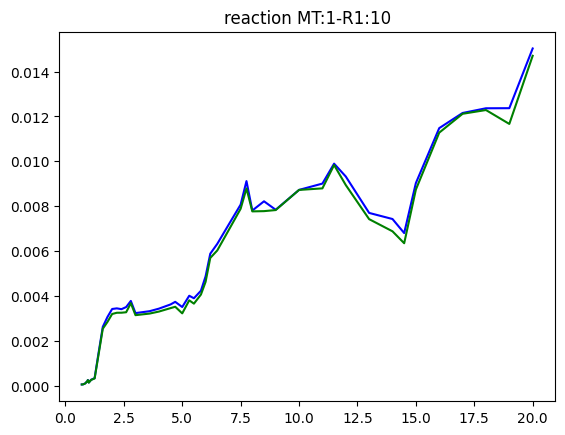

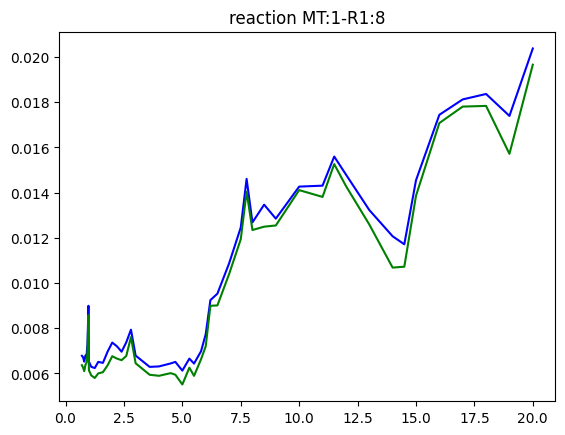

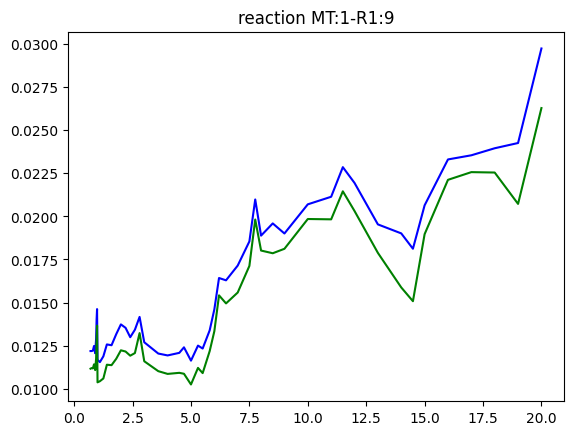

In [12]:
# comparison of posterior uncertainties
grouped = red_priortable.groupby('NODE')
for node, group in grouped:
    if node.startswith('norm_'):
        continue
    if node.startswith('xsid_') and int(node[5:]) not in (8, 9, 10):
        continue
    red_group = group[(group.ENERGY >= 0.7) & (group.ENERGY <= 20)]
    plt.plot(red_group.ENERGY, red_group.POSTUNC_RELCOV_USU, color='blue')
    plt.plot(red_group.ENERGY, red_group.POSTUNC_RELCOV_NOUSU, color='green')
    plt.title(f'reaction {red_group.REAC.iloc[0]}')
    # plt.ylim(0, 0.02)
    plt.show()

## SACS values

In [13]:
exptable['POSTVAL_RELCOV_USU'] = compmap(priortable['POSTVAL_RELCOV_USU'].to_numpy())
exptable['POSTVAL_RELCOV_NOUSU'] = compmap(priortable['POSTVAL_RELCOV_NOUSU'].to_numpy())
rdt = exptable[exptable.REAC.str.match('MT:6-|MT:10-')]
rdt
# x = rdt['POSTVAL_RELCOV_USU'].to_numpy()
# y = rdt['POSTVAL_RELCOV_NOUSU'].to_numpy()
# np.argsort((x-y)/x)[::-1]
# rdt.iloc[[13,14,12]]

,NODE,REAC,ENERGY,DATA,DB_IDX,DS_IDX,AUTHOR,PUBREF,UNC,POSTVAL_RELCOV_USU,POSTVAL_RELCOV_NOUSU
6593,exp_2500,MT:6-R1:8,NaN,1.2160,192,0,Grundl,"GRUNDL MEMO (Rev. Heaton 1976 ABSOL U-235f),in...",0.019699,1.225456,1.223757
6594,exp_2501,MT:10-R1:8-R2:10,NaN,3.7300,192,1,"Grundl, Gilliam","GRUNDL-GILLIAM indc(nds)-146 (1983), p.244, in...",0.044760,3.781226,3.779261
6595,exp_2504,MT:10-R1:8-R2:9,NaN,0.6660,192,2,"Grundl, Gilliam","GRUNDL-GILLIAM indc(nds)-146 (1983), p.244, in...",0.005994,0.674237,0.676835
6596,exp_2505,MT:10-R1:9-R2:8,NaN,1.5000,192,3,Heaton,Heaton 1976 ANL-76-90 60% ratio correl derived...,0.024000,1.483159,1.477465
6597,exp_2506,MT:10-R1:10-R2:8,NaN,0.2644,192,4,Heaton,Heaton 1976 ANL-76-90 60% ratio correl derived...,0.003490,0.264464,0.264602
6598,exp_2507,MT:10-R1:10-R2:8,NaN,0.2690,192,5,Schroeder,Schroeder JANS 50(1985)154,0.003228,0.264464,0.264602
6599,exp_2508,MT:10-R1:9-R2:8,NaN,1.5000,192,6,Schroeder,Schroeder JANS 50(1985)154,0.012000,1.483159,1.477465
6600,exp_2509,MT:6-R1:8,NaN,1.2340,192,7,Schroeder,Schroeder JANS 50(1985)154,0.017893,1.225456,1.223757
6601,exp_2512,MT:6-R1:8,NaN,1.2150,192,8,Knoll,Davis/Knoll ANE 5 (1978) 583,0.021749,1.225456,1.223757
6602,exp_2513,MT:6-R1:9,NaN,1.7900,192,9,Knoll,Davis/Knoll ANE 5 (1978) 583,0.040454,1.817545,1.808058


## Diagnostics of the MCMC chain

It is also important to check whether the MCMC chain behaves well and really targets the posterior distribution. To get a visual impression, we can view traceplots, i.e., the evolution of values over the history of iterations. Here are the traceplots for the cross sections. The title of each plot contains the energy of the cross section and the effective sample size. Please note that the effective sample size can also be higher than the real number of samples obtained due to the fact that Hamilton Monte Carlo potentially performs antithetic sampling. The deterministic evolution of the parameter vector in the parameter space being part of the proposal generation may lead with high probability to a proposal vector that is on the other side of the posterior mean, hence two consecutive values in the chain are anti-correlated, which reduces the variance of the final estimate, see https://en.wikipedia.org/wiki/Antithetic_variates.

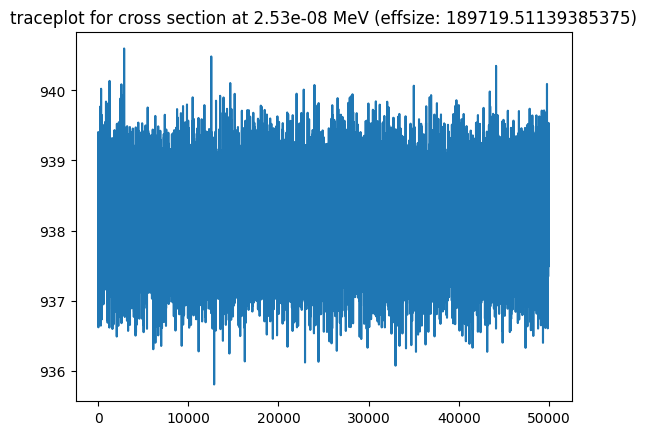

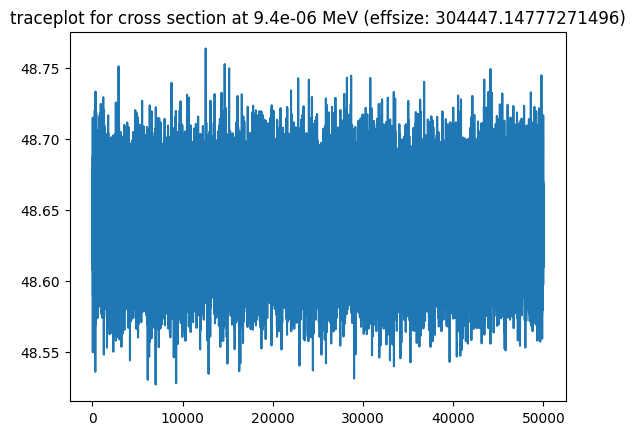

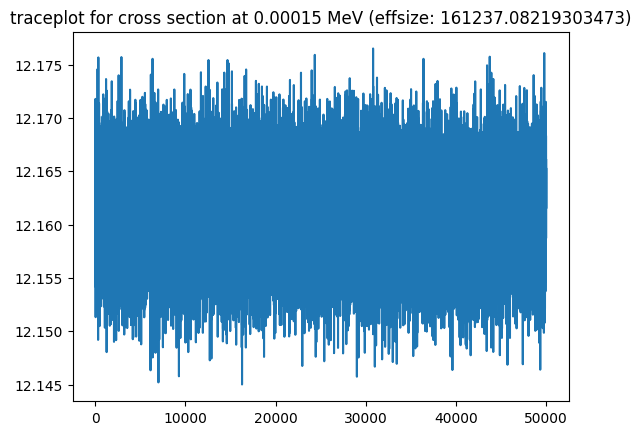

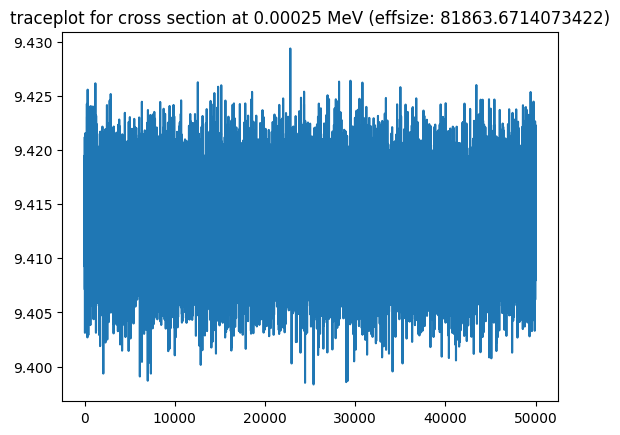

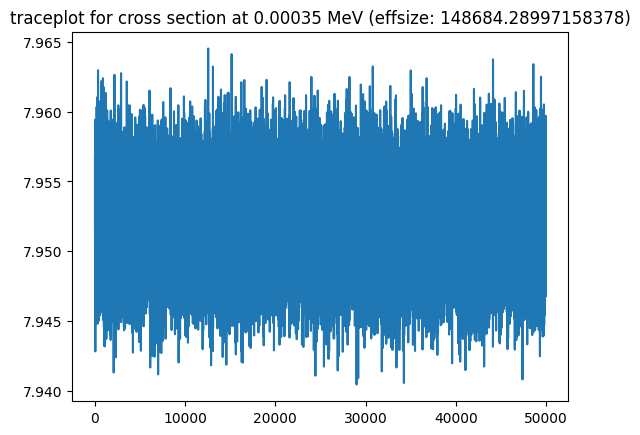

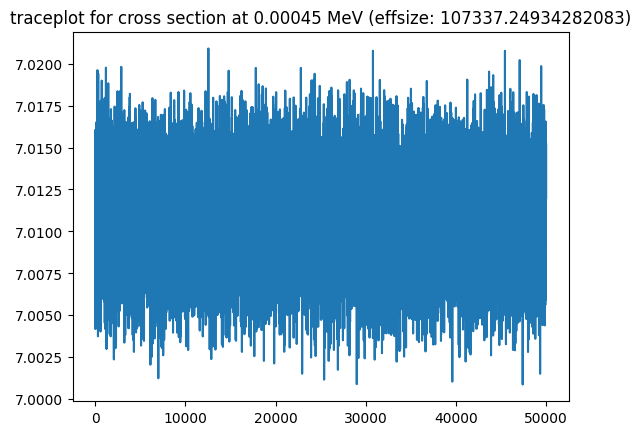

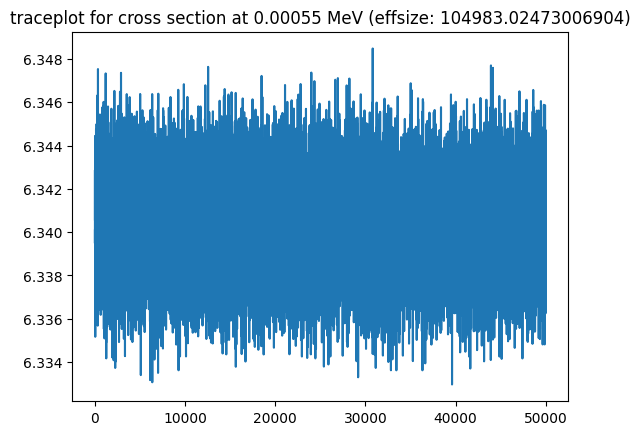

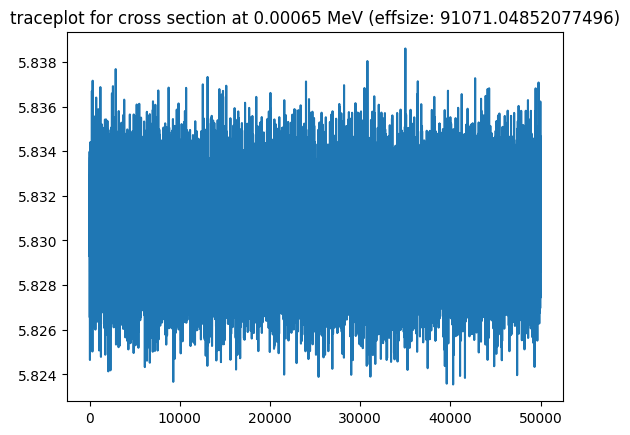

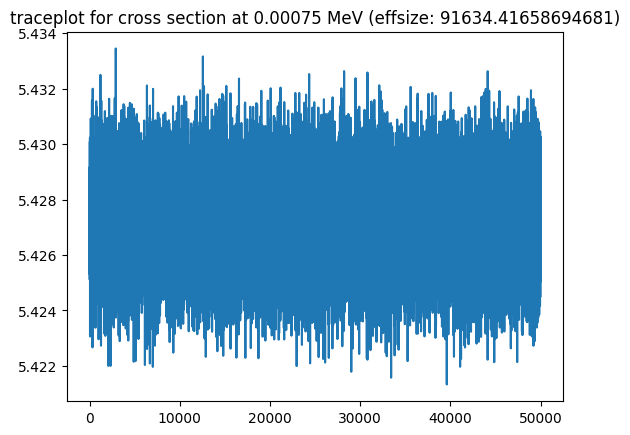

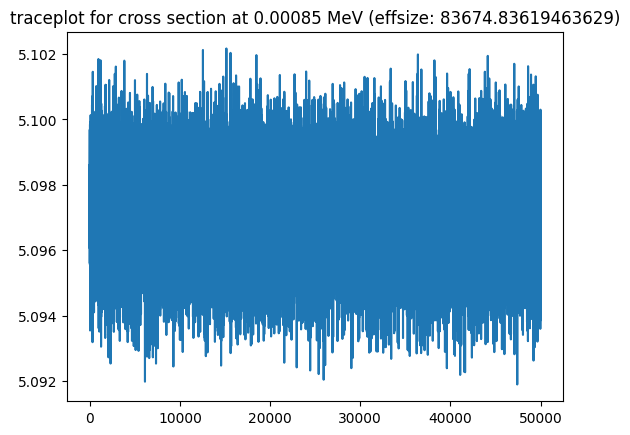

In [14]:
for index, row in priortable[0:10].iterrows():
    curchain = chain_relcov_usu[:,index]
    effsize = compute_effective_sample_size(curchain)
    plt.figure()
    plt.plot(np.arange(len(chain_relcov_usu)), curchain)
    plt.title(f'traceplot for cross section at {row.ENERGY} MeV (effsize: {effsize})')

## Chisquare value comparison

For the proper calculation of the chisquare value, we need into account two factors: First, the evaluated cross section curve is associated with an evaluated covariance matrix. The larger the elements in the evaluated covariance matrix, the more we can tolerate larger deviations of experimental measurement points from the evaluation. Second, larger elements in the experimental covariance matrices also permit larger deviations between evaluated and measured values. Therefore, the correct covariance matrix for the computation of the $\chi^2$-value is given by:
$$\Sigma = \Sigma_{\textrm{exp}} + \Sigma_{\textrm{eval}}$$
In the case of USU uncertainties compiled in the vector $\vec{u}$, the experimental covariance matrix is a function, $\Sigma_{\textrm{exp}}(\vec{u})$. In this case, we could use the posterior expectation value of the experimental covariance matrix, i.e. $E\left[ \Sigma_\textrm{exp}(\vec{u}) \right] = \int \Sigma_\textrm{exp}(\vec{u}) \, du_1 du_2 \dots du_n$. However, to simplify matters for this quick comparison, we use the posterior expectation of the usu uncertainties $\vec{u}$ to construct the covariance matrix, i.e., $\Sigma_\textrm{exp}(E[\vec{u}])$.

In [15]:
# compute the evaluated covariance matrix 
eval_cov = np.cov(chain_relcov_usu[:,:-num_covpars].numpy().T)
# propagate this covariance matrix to the experimental measurementsCloser

ext_postvals_relcov_usu = np.mean(chain_relcov_usu[:, :-num_covpars], axis=0)
jac = tf.sparse.to_dense(restrimap.jacobian(ext_postvals_relcov_usu)).numpy()
eval_cov2 = jac @ eval_cov @ jac.T
# compute the posterior expectation of the USU uncertainties
post_usu_pars = np.mean(np.abs(chain_relcov_usu[:, -num_covpars:]), axis=0)

In [16]:
def chisquare(postvals, covop_linop):
    totcov_linop = eval_cov2 + covop_linop.to_dense().numpy()
    propvals = restrimap(postvals).numpy()
    d = np.reshape(propvals - exptable['DATA'].to_numpy(), (-1, 1))
    chisqr = d.T @ np.linalg.solve(totcov_linop, d) / len(exptable)
    return np.squeeze(chisqr)

def rel2abs_covop(postvals, covop_linop):
    propvals = restrimap(postvals).numpy()
    scale_op = tf.linalg.LinearOperatorDiag(propvals)
    return tf.linalg.LinearOperatorComposition([scale_op, covop_linop, scale_op.adjoint()])

In [17]:
postvals_relcov_usu = np.mean(chain_relcov_usu[:,:-num_covpars], axis=0)
postvals_relcov_nousu = np.mean(chain_relcov_nousu[:,:], axis=0)
postuncs_relcov_usu = np.std(chain_relcov_usu[:,:-num_covpars], axis=0)
postuncs_relcov_nousu = np.std(chain_relcov_nousu[:,:], axis=0)
tmp = rel2abs_covop(postvals_relcov_usu, like_cov_fun_rel_usu(post_usu_pars))
chisquare_relcov_usu = chisquare(postvals_relcov_usu, tmp)
tmp = rel2abs_covop(postvals_relcov_nousu, expcov_rel_nousu)
chisquare_relcov_nousu = chisquare(postvals_relcov_nousu, tmp)
print(f'chisquare with USU augmented experimental covmat: {chisquare_relcov_usu}')
print(f'chisquare with original experimental covmat: {chisquare_relcov_nousu}')

chisquare with USU augmented experimental covmat: 0.8800927719198148
chisquare with original experimental covmat: 0.9018431258790847


## Evaluated values and uncertainties in table form

In [18]:
result_table = pd.DataFrame({
    'DESCR': priortable.DESCR[is_adj],
    'ENERGY': priortable.ENERGY[is_adj],
    'RES_RELCOV_USU': postvals_relcov_usu,
    'UNC_RELCOV_USU': postuncs_relcov_usu / postvals_relcov_usu,
    'RES_RELCOV_NOUSU': postvals_relcov_nousu,
    'UNC_RELCOV_NOUSU': postuncs_relcov_nousu / postvals_relcov_nousu
})
tmpsel = result_table.DESCR.str.match('PU9', na=False) & (result_table.ENERGY >= 1.) & (result_table.ENERGY <= 2)
result_table[tmpsel]

,DESCR,ENERGY,RES_RELCOV_USU,UNC_RELCOV_USU,RES_RELCOV_NOUSU,UNC_RELCOV_NOUSU
742,"PU9(n,f)",1.00,1.743586,0.006703,1.733422,0.005987
743,"PU9(n,f)",1.10,1.762765,0.006551,1.750936,0.005964
744,"PU9(n,f)",1.25,1.865287,0.006373,1.854515,0.005717
745,"PU9(n,f)",1.40,1.944443,0.006468,1.935174,0.005891
746,"PU9(n,f)",1.60,1.967840,0.006367,1.958186,0.005809
747,"PU9(n,f)",1.80,1.969897,0.006685,1.960792,0.005989
748,"PU9(n,f)",2.00,1.997266,0.006878,1.987058,0.006157


## Evaluated correlation matrix

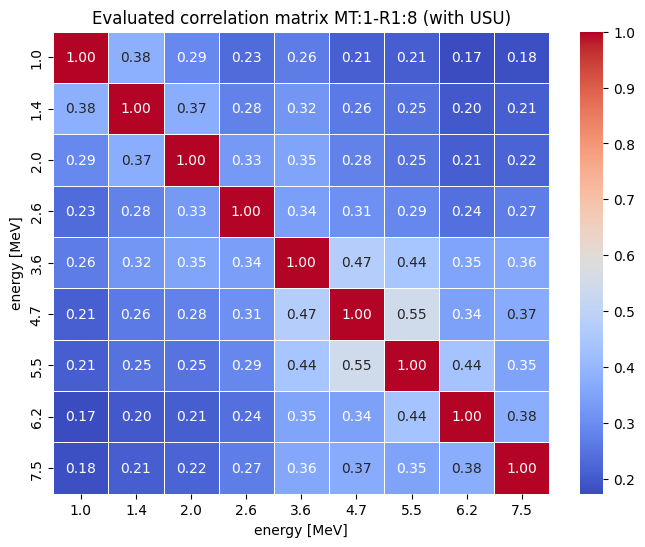

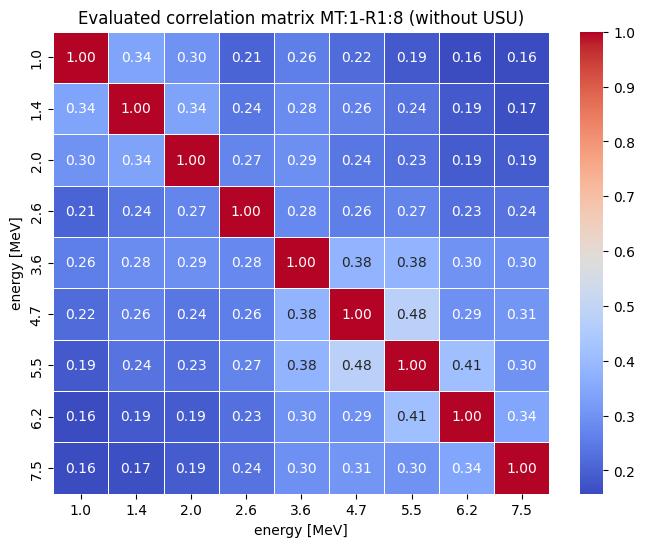

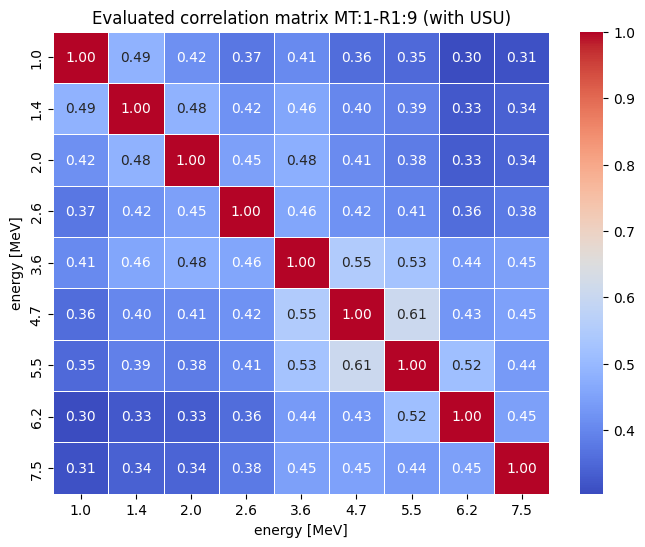

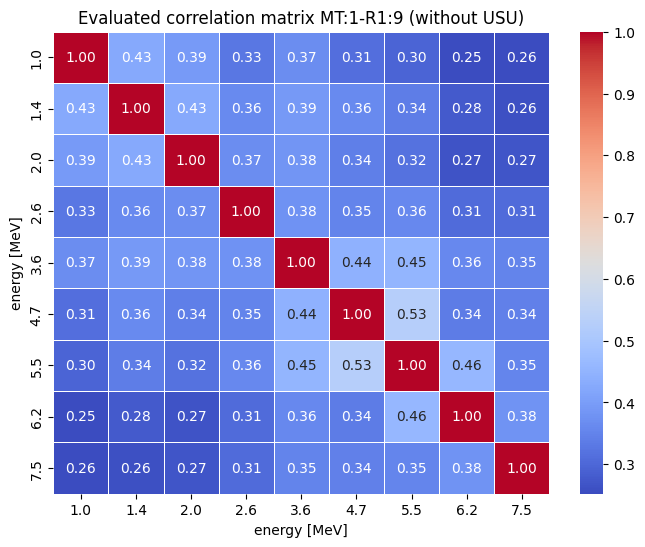

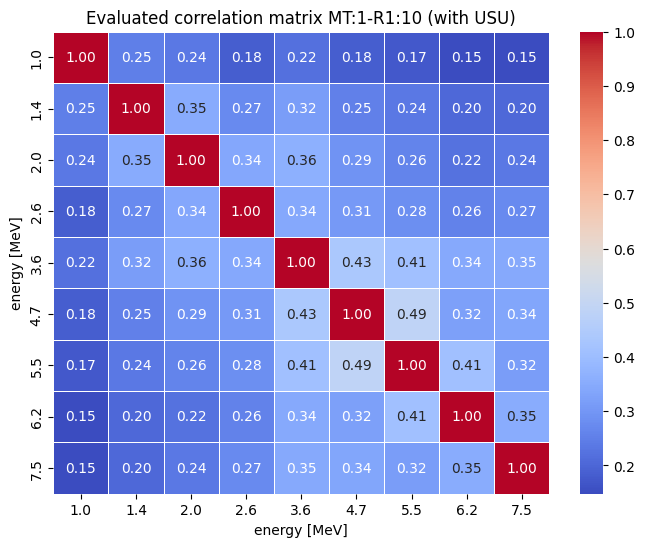

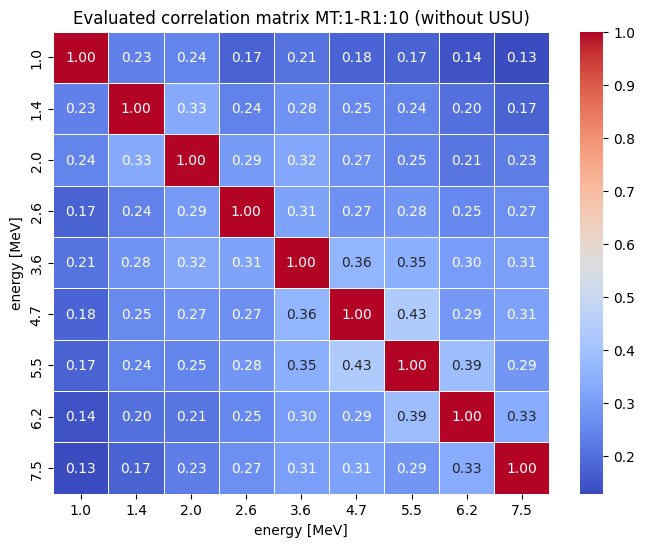

In [19]:
eval_cov_nousu = np.cov(chain_relcov_nousu[:,:-num_covpars].numpy().T)
eval_cov_list = [eval_cov, eval_cov_nousu]
corplot_cases = ['(with USU)', '(without USU)']
# select only the Pu9(n,f)
for cur_reac in ('MT:1-R1:8', 'MT:1-R1:9', 'MT:1-R1:10'):
    idcs = priortable.index[(priortable.REAC == cur_reac) & (priortable.ENERGY >= 1) & (priortable.ENERGY <= 8)]
    idcs = idcs[::3]
    
    for cur_eval_cov, corplot_case in zip(eval_cov_list, corplot_cases):
        std_devs = np.sqrt(cur_eval_cov.diagonal()[idcs])
        eval_cormat = cur_eval_cov[np.ix_(idcs, idcs)] / np.outer(std_devs, std_devs)
        custom_labels = priortable.ENERGY.to_numpy()[idcs]
        plt.figure(figsize=(8, 6))
        heatmap = sns.heatmap(eval_cormat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        heatmap.set_xlabel('energy [MeV]')
        heatmap.set_ylabel('energy [MeV]')
        plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
        plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
        plt.title('Evaluated correlation matrix ' + cur_reac + ' ' + corplot_case)
        plt.show()

## SACS values, uncertainties and correlations

In [20]:
sacs_exp_table = pd.DataFrame({
    'DESCR': ['SACS U5(n,f)', 'SACS PU9(n,f)', 'SACS PU9/SACS U5', 'SACS U8(n,f)', 'SACS U8/SACS U5'],
    'NODE': ['exp_7000', 'exp_7001', 'exp_7002', 'exp_7003', 'exp_7004'],
    'REAC': ['MT:6-R1:8', 'MT:6-R1:9', 'MT:10-R1:9-R2:8', 'MT:6-R1:10', 'MT:10-R1:10-R2:8'],
})

In [21]:
sacs_compmap = CompoundMap((priortable, sacs_exp_table), reduce=True)
sacs_restrmap = RestrictedMap(len(priortable), sacs_compmap.propagate, sacs_compmap.jacobian,
                              fixed_params=priortable.loc[~is_adj, 'PRIOR'].to_numpy(), fixed_params_idcs=np.where(~is_adj)[0])
sacs_restrmap_propagate = tf.function(sacs_restrmap.propagate)
sacs_restrmap_jacobian = tf.function(sacs_restrmap.jacobian)

In [22]:
# with USU (Laplace approx)
eval_sacs_vals_laplace = sacs_restrmap_propagate(priortable.loc[is_adj, 'POST_LAPLACE'].to_numpy())
sacs_jac = tf.sparse.to_dense(sacs_restrmap_jacobian(priortable.loc[is_adj, 'POST_LAPLACE'].to_numpy())).numpy()
tmp_idcs = np.arange(len(priortable.loc[is_adj]))
sacs_cov_laplace = sacs_jac @ postcov[np.ix_(tmp_idcs, tmp_idcs)] @ sacs_jac.T
sacs_uncs_laplace = np.sqrt(sacs_cov_laplace.diagonal())

postcov_diag = np.diag(postcov.diagonal())
sacs_cov_laplace_diag = sacs_jac @ postcov_diag[np.ix_(tmp_idcs, tmp_idcs)] @ sacs_jac.T
sacs_uncs_laplace_diag = np.sqrt(sacs_cov_laplace_diag.diagonal())

# with USU
sacs_chain_relcov_usu = np.zeros((chain_relcov_usu.shape[0], len(sacs_exp_table)), dtype=np.float64)
for i in range(chain_relcov_usu.shape[0]):
    sacs_chain_relcov_usu[i, :] = sacs_restrmap_propagate(chain_relcov_usu[i, :-num_covpars])

# without USU
sacs_chain_relcov_nousu = np.zeros((chain_relcov_nousu.shape[0], len(sacs_exp_table)), dtype=np.float64)
for i in range(chain_relcov_usu.shape[0]):
    sacs_chain_relcov_nousu[i, :] = sacs_restrmap_propagate(chain_relcov_nousu[i, :])

2023-11-17 17:03:40.911383: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 20000 of dimension 0 out of bounds.


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 20000 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [ ]:
eval_sacs_vals = np.mean(sacs_chain_relcov_usu, axis=0)
eval_sacs_covmat = np.cov(np.array(sacs_chain_relcov_usu).T)
eval_sacs_uncs = np.std(sacs_chain_relcov_usu, axis=0)
sacs_exp_table['EVAL_SACS_USU'] = eval_sacs_vals
sacs_exp_table['UNC_SACS_USU'] = eval_sacs_uncs / eval_sacs_vals

eval_sacs_vals_nousu = np.mean(sacs_chain_relcov_nousu, axis=0)
eval_sacs_covmat_nousu = np.cov(np.array(sacs_chain_relcov_nousu).T)
eval_sacs_uncs_nousu = np.std(sacs_chain_relcov_nousu, axis=0)
sacs_exp_table['EVAL_SACS_NOUSU'] = eval_sacs_vals_nousu
sacs_exp_table['UNC_SACS_NOUSU'] = eval_sacs_uncs_nousu / eval_sacs_vals_nousu

sacs_exp_table['EVAL_SACS_USU_LAPLACE'] = eval_sacs_vals_laplace
sacs_exp_table['UNC_SACS_USU_LAPLACE'] = sacs_uncs_laplace / eval_sacs_vals_laplace
sacs_exp_table['UNC_SACS_USU_LAPLACE_DIAG'] = sacs_uncs_laplace_diag / eval_sacs_vals_laplace
sacs_exp_table

In [ ]:
sacs_exp_table[['DESCR',  'REAC', 'EVAL_SACS_USU_LAPLACE', 'UNC_SACS_USU_LAPLACE', 'UNC_SACS_USU_LAPLACE_DIAG']]

In [ ]:
eval_sacs_cormat = eval_sacs_covmat / np.outer(eval_sacs_uncs, eval_sacs_uncs)
custom_labels = sacs_exp_table['DESCR']
heatmap = sns.heatmap(eval_sacs_cormat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.title('Posterior SACS correlation matrix (with USU)')
plt.show()

In [ ]:
eval_sacs_cormat_nousu = eval_sacs_covmat_nousu / np.outer(eval_sacs_uncs_nousu, eval_sacs_uncs_nousu)
custom_labels = sacs_exp_table['DESCR']
heatmap = sns.heatmap(eval_sacs_cormat_nousu, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
plt.title('Posterior SACS correlation matrix (no USU)')
plt.show()

## Plot correlations of the posterior of the differential data according to the Laplace approximation

In [ ]:
idcs = priortable.index[(priortable.ENERGY >= 0.5) & (priortable.ENERGY <= 10) & (priortable.REAC == 'MT:1-R1:9')]
np.sqrt(np.diag(postcov[np.ix_(idcs, idcs)])) / priortable.POST_LAPLACE.loc[idcs,]

In [ ]:
for cur_reac in ('MT:1-R1:8', 'MT:1-R1:9', 'MT:1-R1:10'):
    idcs = priortable.index[(priortable.REAC == cur_reac) & (priortable.ENERGY >= 1) & (priortable.ENERGY <= 8)]
    idcs = idcs[::3]
    std_devs = np.sqrt(postcov.diagonal()[idcs])
    eval_cormat = postcov[np.ix_(idcs, idcs)] / np.outer(std_devs, std_devs)
    custom_labels = priortable.ENERGY.to_numpy()[idcs]
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(eval_cormat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    heatmap.set_xlabel('energy [MeV]')
    heatmap.set_ylabel('energy [MeV]')
    plt.xticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
    plt.yticks(np.arange(len(custom_labels)) + 0.5, custom_labels)
    plt.title('Evaluated correlation matrix ' + cur_reac)
    plt.show()